In [1]:
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from skimage.metrics import mean_squared_error, structural_similarity
import tensorflow as tf

In [2]:
# Step 1: Load and Preprocess CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the images for SOM (32x32x3 to 1D vector)
x_train_flattened = x_train.reshape(-1, 32*32*3)
x_test_flattened = x_test.reshape(-1, 32*32*3)

In [33]:
# Step 2: Initialize SOM with Dynamic Learning Rate and Neighborhood Function
som_grid_size = (20, 20)  # Grid of 20x20 neurons
initial_learning_rate = 0.6
initial_sigma = 4.0  # Initial neighborhood radius
num_iterations = 5000

In [34]:
# Create SOM instance
som = MiniSom(som_grid_size[0], som_grid_size[1], 32*32*3, sigma=initial_sigma, learning_rate=initial_learning_rate)
som.random_weights_init(x_train_flattened)

In [35]:
# Step 3: Train the SOM with dynamic learning rate and neighborhood
def train_som(som, data, num_iterations):
    for i in range(num_iterations):
        # Dynamic learning rate and sigma (neighborhood size)
        lr = initial_learning_rate * (1 - i / num_iterations)
        sigma = initial_sigma * (1 - i / num_iterations)
        
        # Select a random sample from the dataset
        random_sample = data[np.random.randint(0, len(data))]
        
        # Train SOM with updated learning rate and neighborhood
        som.update(random_sample, som.winner(random_sample), lr, sigma)

# Train SOM on CIFAR-10 training data
train_som(som, x_train_flattened, num_iterations)

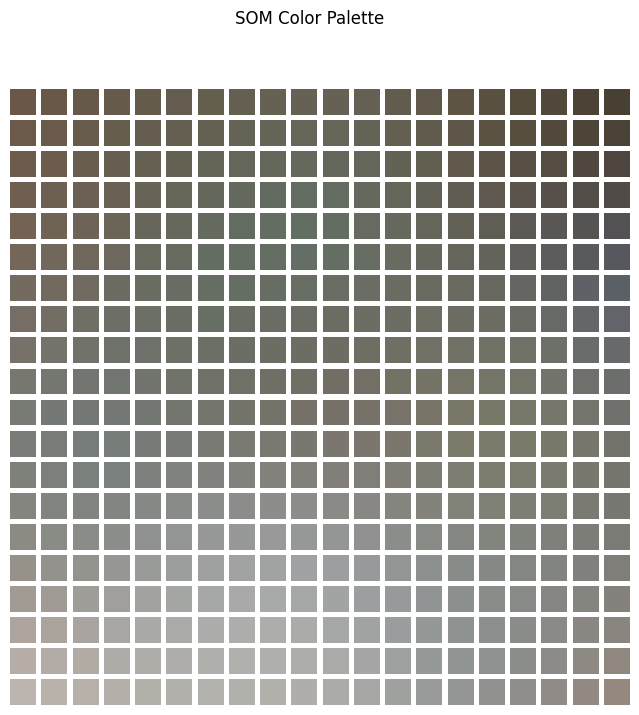

In [36]:
# Step 4: Visualize the SOM Color Palette
palette = som.get_weights()

plt.figure(figsize=(8, 8))
for i in range(som_grid_size[0]):
    for j in range(som_grid_size[1]):
        # Average the SOM weights to a 3D color (RGB values between 0 and 1)
        color = palette[i, j].reshape(32, 32, 3).mean(axis=(0, 1))  # Average across all pixels
        plt.subplot(som_grid_size[0], som_grid_size[1], i * som_grid_size[1] + j + 1)
        plt.imshow(np.ones((1, 1, 3)) * color)  # Show the averaged color
        plt.axis('off')
plt.suptitle("SOM Color Palette")
plt.show()

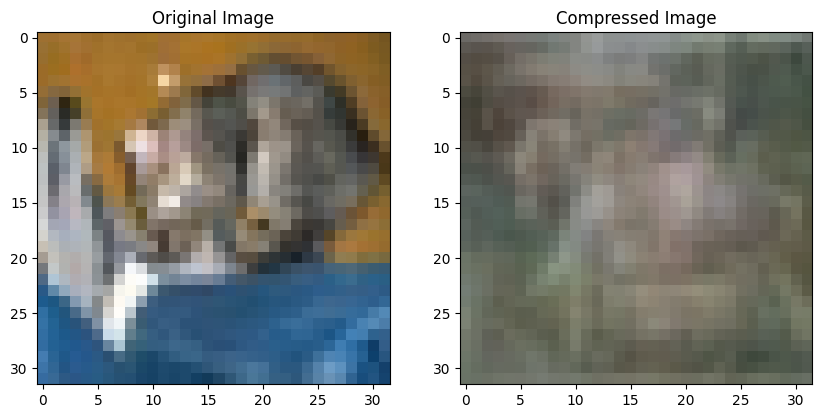

In [37]:
# Step 5: Image Compression using the SOM
def compress_image(image, som):
    """
    Compress an image using the SOM by mapping each 32x32x3 image to the closest SOM weight.
    """
    # Flatten the entire image to a 3072-element vector
    flattened_image = image.flatten()  # (32x32x3 = 3072)
    
    # Find the Best Matching Unit (BMU) for the entire image
    bmu = som.winner(flattened_image)  # Get BMU for the full image vector
    
    # Replace the entire image with the BMU weight (compressed color)
    compressed_image = som.get_weights()[bmu].reshape(32, 32, 3)  # Reshape the BMU weight back to image dimensions (32x32x3)
    
    return compressed_image

# Step 6: Compress a sample image from the test set
image_to_compress = x_test[0]  # Use the first image from the test set
compressed_image = compress_image(image_to_compress, som)

# Plot original and compressed images side by side
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_to_compress)

# Compressed image
plt.subplot(1, 2, 2)
plt.title('Compressed Image')
plt.imshow(compressed_image)
plt.show()


Mean Squared Error (MSE): 0.036768160930862
Structural Similarity Index (SSIM): 0.18360860645771027
Original image size: 12288 bytes
Compressed image size: 24576 bytes


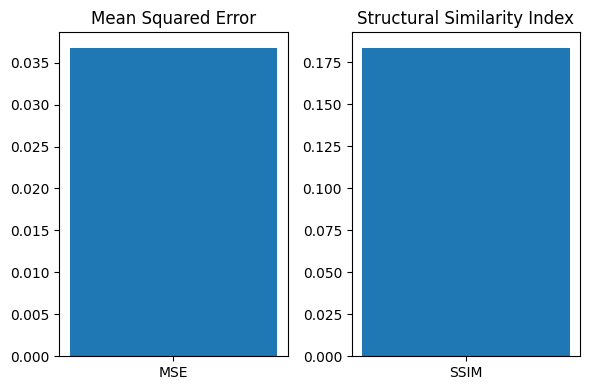

In [38]:
# Step 7: Calculate and Display Performance Metrics (MSE, SSIM)
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(image_to_compress, compressed_image)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Structural Similarity Index (SSIM) with a smaller window size and using channel_axis instead of multichannel
ssim = structural_similarity(image_to_compress, compressed_image, win_size=5, channel_axis=-1, data_range=1)
print(f'Structural Similarity Index (SSIM): {ssim}')

# File size comparison (in-memory size comparison)
original_size = image_to_compress.nbytes
compressed_size = compressed_image.nbytes

print(f"Original image size: {original_size} bytes")
print(f"Compressed image size: {compressed_size} bytes")

# Step 8: Plot the results of MSE and SSIM
plt.figure(figsize=(6, 4))

# MSE bar plot
plt.subplot(1, 2, 1)
plt.bar(['MSE'], [mse])
plt.title('Mean Squared Error')

# SSIM bar plot
plt.subplot(1, 2, 2)
plt.bar(['SSIM'], [ssim])
plt.title('Structural Similarity Index')

plt.tight_layout()
plt.show()
